# ASL Project

In [1]:
#Import libraries
import numpy as np
import random

# Imports to view data
import cv2
import pandas as pd
from glob import glob

# Visualization
from keras.utils import print_summary
from matplotlib import pyplot as plt

#ML libraries
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint  
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

Using TensorFlow backend.


In [2]:
#Directory paths
TRAIN_DIR = "../Dataset/asl_alphabet_train/asl_alphabet_train"
TEST_DIR = "../Dataset/asl_alphabet_test"
MODEL_DIR = './Model'
MODEL_PATH = MODEL_DIR+"/FinalModel.h5"
MODEL_WEIGHT_PATH = MODEL_DIR+"/FinalModel_Weight.h5"

In [3]:
# Set global variables
TARGET_SIZE = (64, 64)
TARGET_DIMS = (64, 64, 3) # add channel for RGB
CLASSES = 29
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 64

## Data Visualization

In [4]:
#Labels for diffrent classes
LABELS_NAME = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q',
               'R','S','T','U','V','W','X','Y','Z','del','nothing','space']

In [5]:
#Function to plot randomly one image from each class.
def plot_sample(base_path):
    cols = 5
    rows = int(np.ceil(len(LABELS_NAME) / cols))
    fig = plt.figure(figsize=(16, 20))
    
    for i in range(len(LABELS_NAME)):
        folder_name = LABELS_NAME[i]
        img_path = base_path +'/' + folder_name + '/**'
        path_contents = glob(img_path)
    
        imgs = random.sample(path_contents, 1)

        sp = plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.imread(imgs[0]))
        plt.title(folder_name)
        sp.axis('off')

    plt.show()
    return

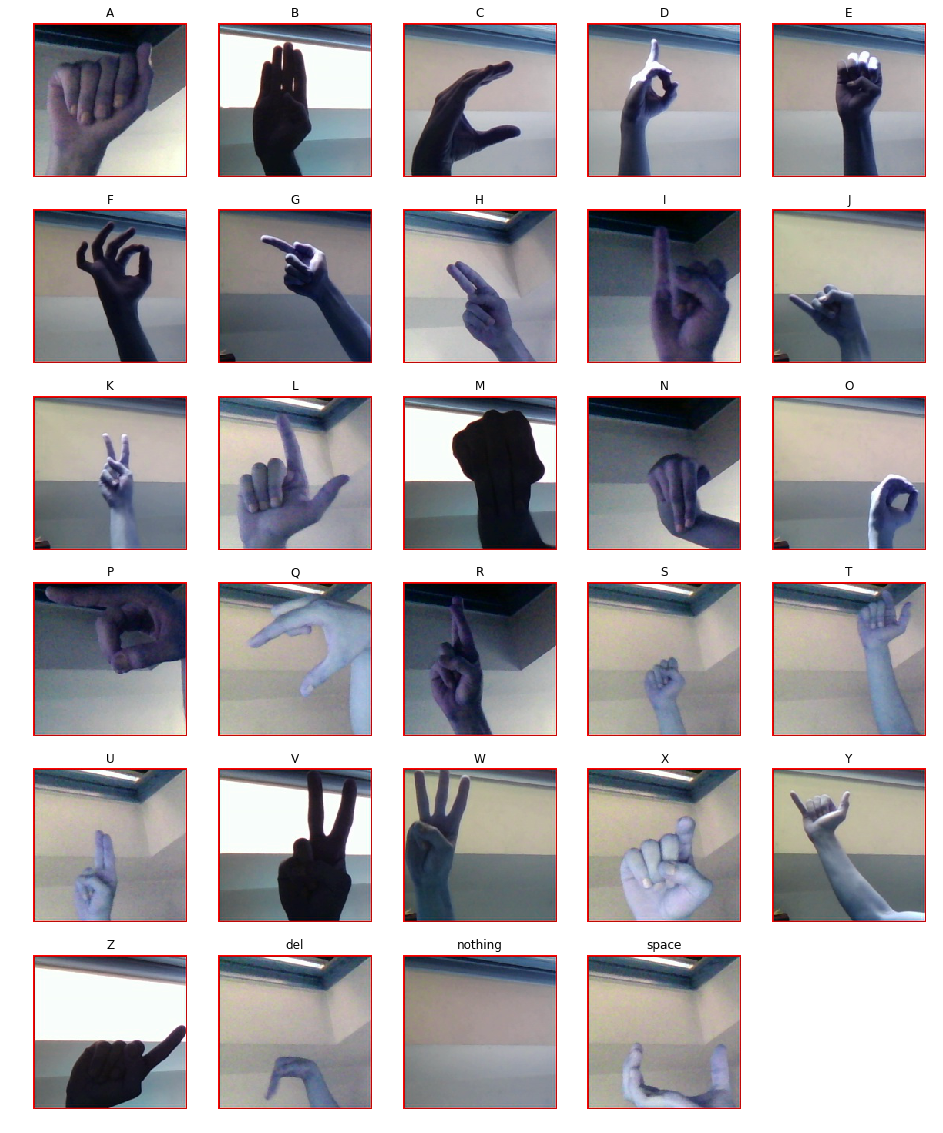

In [6]:
#Plot sample of train dataset
plot_sample(TRAIN_DIR)

In [19]:
def histogram_for_color_channels(image_path):
    img = cv2.imread(image_path)

    #showing the image
    plt.imshow(img)
    plt.show()
    
    color = ('b','g','r')
    fig = plt.figure()

    for i,col in enumerate(color):
        histr = cv2.calcHist([img],[i],None,[200],[0,200])
        plt.plot(histr,color = col)
        plt.xlim([0,200])
    
    #showing the histogram
    plt.xlabel("value of the pixel for the given channel")
    plt.ylabel("Number of pixels")
    plt.show()

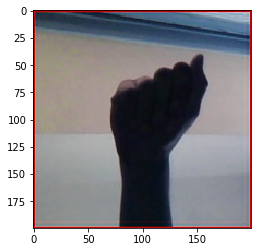

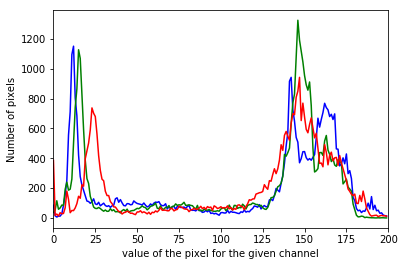

In [20]:
histogram_for_color_channels(TRAIN_DIR+'/A/A31.jpg')

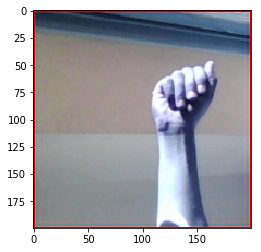

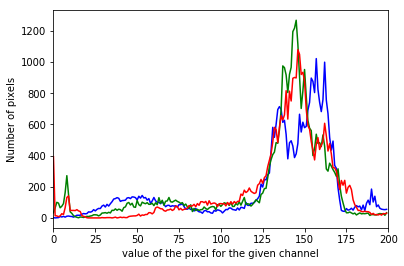

In [12]:
histogram_for_color_channels(TRAIN_DIR+'/A/A617.jpg')

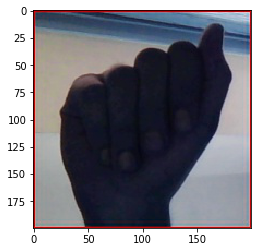

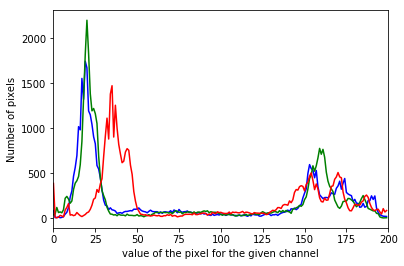

In [13]:
histogram_for_color_channels(TRAIN_DIR+'/A/A894.jpg')

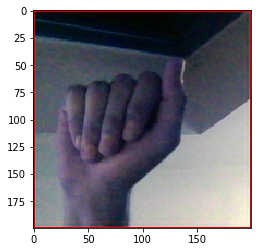

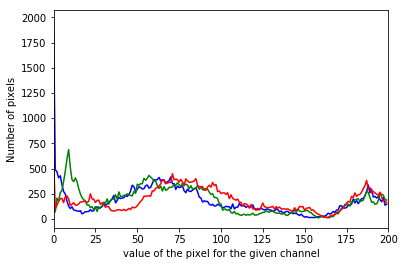

In [14]:
histogram_for_color_channels(TRAIN_DIR+'/A/A2417.jpg')

## Data Augmentation

In [4]:
#Load Train dataset
train_image_generator = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=VALIDATION_SPLIT
)

validation_image_generator = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    validation_split=VALIDATION_SPLIT
)

train_generator = train_image_generator.flow_from_directory(TRAIN_DIR, target_size=TARGET_SIZE, batch_size=BATCH_SIZE, shuffle=True, subset="training")
val_generator = validation_image_generator.flow_from_directory(TRAIN_DIR, target_size=TARGET_SIZE, batch_size=BATCH_SIZE, subset="validation")

Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


## Model

In [5]:
#Define Model Xception Model
def Xception_model_build():
    from keras.applications.xception import Xception
    from keras.layers import Input

    input_tensor = Input(shape=TARGET_DIMS)
    model = Xception(input_tensor = input_tensor, weights=None, include_top=True, classes= CLASSES)
    return model

In [6]:
from keras.models import Model
base_model = Xception_model_build()
x = base_model.output
#x = (Dense(CLASSES, activation='softmax'))(x)
model = Model(inputs=base_model.input, outputs=x)

#Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
model.summary()
model.save(MODEL_PATH)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 31, 31, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 31, 31, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 31, 31, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [12]:
#Checkpointer to save the best models
checkpointer = ModelCheckpoint(filepath=MODEL_WEIGHT_PATH, 
                               verbose=1, save_best_only=True)

steps_per_epoch = int( np.ceil(len(train_generator)*2 / BATCH_SIZE) )
validation_steps = int( np.ceil(len(val_generator)*2 / BATCH_SIZE) )

history = model.fit_generator(train_generator, validation_data=val_generator, 
                    steps_per_epoch =  steps_per_epoch,
                    validation_steps = validation_steps,
                    epochs=50, callbacks=[checkpointer], verbose=1)

Epoch 1/50
39/39 [==============================] - 267s 7s/step - loss: 2.9346 - acc: 0.1182 - val_loss: 15.6648 - val_acc: 0.0281

Epoch 00001: val_loss improved from inf to 15.66477, saving model to ./Model/FinalModel_Weight.h5
Epoch 2/50
39/39 [==============================] - 268s 7s/step - loss: 2.6939 - acc: 0.1767 - val_loss: 13.2198 - val_acc: 0.0375

Epoch 00002: val_loss improved from 15.66477 to 13.21983, saving model to ./Model/FinalModel_Weight.h5
Epoch 3/50
39/39 [==============================] - 272s 7s/step - loss: 2.4899 - acc: 0.2139 - val_loss: 14.3248 - val_acc: 0.0406

Epoch 00003: val_loss did not improve from 13.21983
Epoch 4/50
39/39 [==============================] - 276s 7s/step - loss: 2.3047 - acc: 0.2612 - val_loss: 14.8039 - val_acc: 0.0406

Epoch 00004: val_loss did not improve from 13.21983
Epoch 5/50
39/39 [==============================] - 273s 7s/step - loss: 2.1789 - acc: 0.2941 - val_loss: 11.9427 - val_acc: 0.0813

Epoch 00005: val_loss improved

# Visualization of training the model

In [13]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


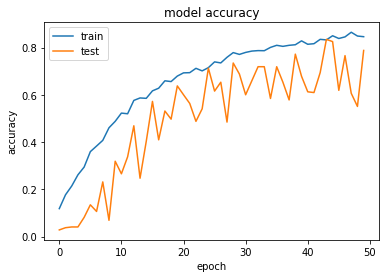

In [14]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

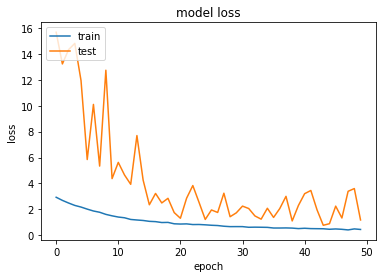

In [15]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
#Predict on validation dataset
predictions = model.predict_generator(val_generator, steps=1)        
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v

predictions = [label_map[k] for k in predictions]

print(predictions, len(predictions))

loss, acc = model.evaluate_generator(val_generator, steps=1, verbose=0)

print(loss,",",acc)

['J', 'L', 'C', 'Y', 'C', 'P', 'T', 'W', 'F', 'R', 'space', 'Q', 'G', 'Z', 'W', 'Y', 'nothing', 'K', 'V', 'Z', 'G', 'J', 'B', 'V', 'D', 'nothing', 'Q', 'G', 'S', 'S', 'G', 'B', 'E', 'M', 'R', 'V', 'C', 'R', 'S', 'N', 'V', 'B', 'U', 'J', 'F', 'Y', 'L', 'S', 'S', 'E', 'P', 'space', 'J', 'U', 'M', 'S', 'I', 'Q', 'E', 'L', 'Z', 'nothing', 'Y', 'Q'] 64
1.1895140409469604 , 0.78125


In [17]:
test_image_generator = ImageDataGenerator(
    samplewise_center = True,
    samplewise_std_normalization = True,
)

test_generator = test_image_generator.flow_from_directory(TEST_DIR, target_size=TARGET_SIZE, batch_size=28, shuffle=False, 
    class_mode='categorical')
print(test_generator.classes)

Found 28 images belonging to 1 classes.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [18]:
#Predict
test_generator.reset()
predictions = model.predict_generator(test_generator, steps=1)
predictions = np.argmax(predictions, axis=1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v

predictions = [label_map[k] for k in predictions]

print(predictions, len(predictions))

['S', 'B', 'G', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'R', 'L', 'M', 'N', 'P', 'P', 'Q', 'U', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'R', 'nothing', 'space'] 28


In [20]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
#print(results)

In [21]:
count = 0
for file,prediction in zip(filenames,predictions):
    #print(file,prediction)
    if(prediction+'_test' in file):
        count+=1
        
print("accuracy",count/len(filenames)*100)

accuracy 78.57142857142857
